*Master IASD, PSL - 2023/2024 - O. Cappé, February 2024*

# Retail Store Management

**This is your INDIVIDUAL homework that needs to be returned by March 25, 2024, at the latest, as a functional completed Python notebook file. Late submissions will be applied a penalty.** Please print your name here and be sure to name your file <code>YourFirstName-YOURLASTNAME-retail_store.ipynb</code> and to send it by email to <olivier.cappe@ens.fr> before the deadline.

We consider, the retail store management model seen in the first course.

You own a bike store. During week $t$, the demand is $D_t$ units, which we may assume to be $\operatorname{Poisson}(d)$ distributed, independently of the past. On Monday morning you may choose to command $A_t$ additional units that are delivered immediately before the shop opens. For each week,

- Maintenance Cost: $h$ per unit left in your stock from previous week
- Ordering Cost: $c$ per ordered unit
- Sales Profit: $f$ per sold unit

With the following constraints

- Your warehouse has a maximal capacity of $m$ unit (any additional bike gets stolen)
- You cannot sell bikes that you don’t have in stock

We will consider that $\mathcal{A}=\mathcal{S}=\{0,\dots,m\}$ and the MDP evolves according to

- $D_t \sim \operatorname{Poisson}(d)$
- $X_t = -h S_t -c A_t + f \min(D_t, S_t + A_t, m)$
- $S_{t+1} = \max(0, \min(S_t+A_t,m)-D_t)$

In [337]:
# Please REFRAIN from importing any additional module
import math
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [338]:
np.set_printoptions(suppress=True)

## The Retail Store Environment

The <code>RetailStore</code> class defines the environnement, providing the basic functions for interacting with the system (<code>env.reset</code> and <code>env.step</code>) and for computing basic parameter-dependent quantities (reward and transition functions, value function of a policy).

In [339]:
# Utility functions for the Retail store environment (do NOT modify this code block)

class RetailStore:
    def __init__(self, m, h, c, f, d):
        self.m = m # Stock capacity
        self.h = h # Maintenance cost per unit
        self.c = c # Buying price per unit
        self.f = f # Selling price per unit
        self.d = d # Weekly average demand
        
    def reset(self, state):
        """ Restarts the environment at time 0 in specified state. """
        self.state = state
        self.time = 0

    def step(self, action):
        """ Given the action, performs one call to the environment and return the reward. """
        demand = poisson.rvs(self.d)
        reward = -self.h*self.state -self.c*action + self.f*min([demand, self.state+action, self.m])
        # Update the time and state variables
        self.time += 1
        self.state = max([min([self.state+action, self.m])-demand, 0])
        return reward

    def reward_function(self):
        """ Computes the action-depend reward function r(s,a). """
        r = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                # Note: computing the expectation of the truncated Poisson distribution using the survival function
                r[s, a] = -self.h*s -self.c*a + self.f*sum(poisson.sf(np.linspace(0, min(s+a, self.m)-1, num=min(s+a, self.m)), self.d))
        return r

    def transition_function(self):
        """ Computes the action-depend transition probabilities p(s,a,s'). """
        p = np.zeros((self.m+1, self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                for i in range(min(s+a, self.m)):
                    p[s, a, min(s+a, self.m)-i] = poisson.pmf(i, self.d)
                p[s, a, 0] = poisson.sf(min(s+a, self.m)-1, self.d)
        return p

    def reward_policy(self, pi):
        """ Computes the reward function r_pi(s) associated with a policy. """
        r = self.reward_function()
        r_pi = np.sum(np.multiply(r, pi), axis=1)
        return r_pi

    def transition_policy(self, pi):
        """ Computes the transition probabilities p_pi(s,s') associated with a policy. """
        p = self.transition_function()
        p_pi = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            p_pi[s,:] = np.matmul(np.transpose(pi[s,:]), p[s,:,:])
        return p_pi

    def value_policy(self, pi, gamma):
        """ Computes the value function of a policy, with discount gamma (using matrix inversion). """
        r_pi = self.reward_policy(pi)
        p_pi = self.transition_policy(pi)
        v_pi = np.linalg.solve(np.eye(self.m+1) - gamma* p_pi, r_pi)
        return v_pi        

## Experiments

### Q1. Simulation of Fixed Ordering Policies

We will consider a small-size model in which $[m, h, c, f, d, \gamma] = [9, 0.1, 0.5, 1, 4, 0.875]$ **(Comment these choice of parameters).** By simulating trajectories from the model **(discuss what length is necessary)** get an empirical idea of **how well fixed-ordering (i.e. ordering always the same quantity of goods) perform?** Use the <code>env.value_policy</code> to **plot the value functions of the fixed-ordering policies.** **What is your interpretation of the results? Do you think that there are better policies?**

**About the choice of the parameters**
- m=9 means we can't have more than 9 bikes (=10 possible states), keeping m low allows use to use numerical approaches with low computational cost
- h=0.1, c=0.5, f=1, seems fair. The retailer sells the bike for twice the price he bought it and he pays 20% of its price per week to maintain it
- d=4. The demand follows a Poisson(4) distribution -> OK, why not
- $\gamma =0.875$ seems a bit weird at first, we have a finite time n=12 weeks, why should the reward in 12 weeks be worth $\gamma^{n-1} = 0.875^{11}=0.23$ times the reward right at the start ? $\gamma$ can represent an inflation parameter, but it's set too low. I would rather use $\gamma = 0.999$, so that $\gamma^{11} = 0.989$ therefore representing an inflation of ~1% in 12 weeks. <br>
  Setting gamma low pushes the agent to take good decisions as fast as possible

In [340]:
# Instantiate the retail store environment with the selected parameters 
[m, h, c, f, d, gamma] = [9, 0.1, 0.5, 1, 4, 0.875]
env = RetailStore(m, h, c, f, d)

# Fixed-order policy
FixOrd = 4

# Just an example of simulating a short trajectory and computing the cumulated reward  
env.reset(m)
n = 40
w = 1
v = 0
for _ in range(n):
    x = env.step(FixOrd)
    print(env.time-1, ': ', '{:.1f}'.format(x), ' ->', env.state)
    v += w*x
    w *= gamma
print('Discounted reward:', '{:.1f}'.format(v))

0 :  2.1  -> 4
1 :  4.6  -> 1
2 :  -1.1  -> 4
3 :  3.6  -> 2
4 :  3.8  -> 0
5 :  1.0  -> 1
6 :  0.9  -> 2
7 :  1.8  -> 2
8 :  1.8  -> 2
9 :  -0.2  -> 4
10 :  1.6  -> 4
11 :  1.6  -> 4
12 :  4.6  -> 1
13 :  2.9  -> 0
14 :  1.0  -> 1
15 :  0.9  -> 2
16 :  2.8  -> 1
17 :  1.9  -> 1
18 :  0.9  -> 2
19 :  -1.2  -> 5
20 :  -0.5  -> 7
21 :  3.3  -> 3
22 :  2.7  -> 2
23 :  1.8  -> 2
24 :  -0.2  -> 4
25 :  0.6  -> 5
26 :  0.5  -> 6
27 :  5.4  -> 1
28 :  1.9  -> 1
29 :  2.9  -> 0
30 :  2.0  -> 0
31 :  2.0  -> 0
32 :  1.0  -> 1
33 :  0.9  -> 2
34 :  -0.2  -> 4
35 :  -1.4  -> 7
36 :  3.3  -> 3
37 :  3.7  -> 1
38 :  2.9  -> 0
39 :  1.0  -> 1
Discounted reward: 15.9


In [341]:
print("Discount factor after 12 weeks :", np.power(gamma, 12))
print("Discount factor after 20 weeks :", np.power(gamma, 20))
print("Discount factor after 40 weeks :", np.power(gamma, 40))

Discount factor after 12 weeks : 0.2014172380004311
Discount factor after 20 weeks : 0.06920875877393026
Discount factor after 40 weeks : 0.0047898522910280695


**About the length of the trajectory...**

After 40 weeks, the discount factor is 0.48% which means the value doesn't change much after that. Setting n=40 is fine.

**Let's visualize the result of every Fixed order buy policy 0 through 9**

In [342]:
def get_deterministic_pi_matrix(pi, m):
    '''
    converts a deterministic policy array pi to its equivalent in a matrix.
    pi has to be an array of length m, containing the action to take at each state
    '''
    pi_matrix = np.zeros(shape=(m+1,m+1), dtype=np.int8)
    for state, action in enumerate(pi):
        pi_matrix[state, action]=1
    return pi_matrix

#Example
get_deterministic_pi_matrix(range(10), 9)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int8)

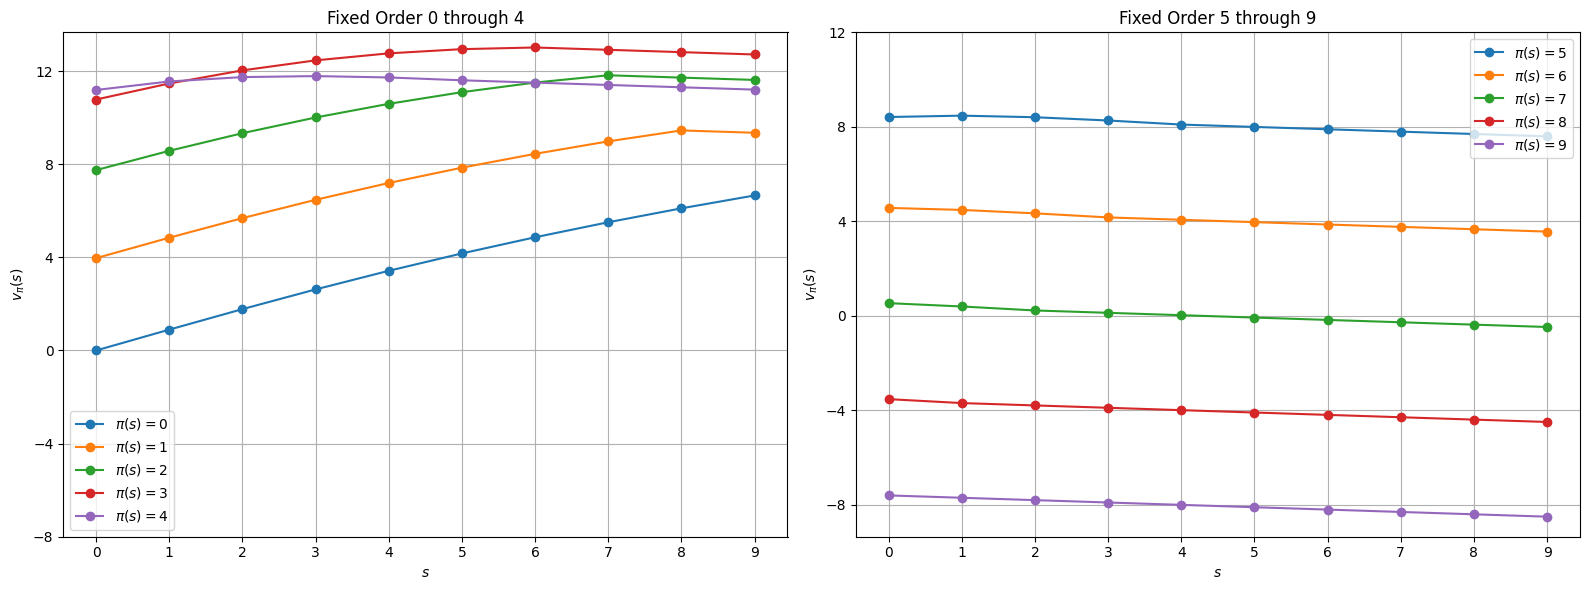

In [343]:
fig, (axLeft, axRight) = plt.subplots(1,2, figsize=(16,6))
for FixOrd in range(10):
    pi = get_deterministic_pi_matrix([FixOrd]*(m+1), m)
    if FixOrd<5 :
        axLeft.plot(env.value_policy(pi, gamma), label=r"$\pi(s)=%d$" %FixOrd, marker="o")
        axLeft.legend()
        axLeft.set_xlabel(r"$s$")
        axLeft.set_ylabel(r"$v_{\pi}(s)$")
        axLeft.set_title("Fixed Order 0 through 4")
        axLeft.set_xticks(range(10))
        axLeft.set_yticks(range(-8, 14, 4))
        axLeft.grid(True)
    else :
        axRight.plot(env.value_policy(pi, gamma), label=r"$\pi(s)=%d$" %FixOrd, marker="o")
        axRight.legend()
        axRight.set_xlabel(r"$s$")
        axRight.set_ylabel(r"$v_{\pi}(s)$")
        axRight.set_title("Fixed Order 5 through 9")
        axRight.set_xticks(range(10))
        axRight.set_yticks(range(-8, 14, 4))
        axRight.grid(True)
plt.tight_layout()
plt.show()

- The best fixed-order policy seems to 3. <br>
- Below 3, the retailer doesn't buy enough bikes in respect to the demand ($D_t$ follows a $Poisson(4)$ distribution of mean 4), so he doesn't exploit his demand's potential. <br> 
For $s \geq m-FixOrd$ we can see the value decreasing, which makes sense because the retailer has a warehouse capacity of maximum m. <br> For example for FixOrd = 2, it doesn't make sense to buy 2 bikes when you already have 8 or 9 bikes in your warehouse, so the value decreases.
- Above 4, the retailer buys too many bikes in respect to the demand, he ends up having to store a lot of unsold bikes and wastes money when ordering too much for his warehouse capacity. Especially for $\pi(s,k)$ for $k\geq7$, the value becomes negative. <br>
- By instinct, I would have said the best fixed-order policy should be 4, becomes we chose d=4. But in hindsight, it's not that surprising to see 3 being better than 4 for $s \geq 2$ because of the maintenance cost : If his previous stock is high, the retailer should always prioritize selling his previous bikes before ordering new bikes especially with a discount factor of 0.875
  
There's certainly a better policy than the FixOrd = 3 policy : When the stock is above 7, simply change FixOrd to $min(m-s, FixOrd)$

In [344]:
# Storing the fixed-order 3 policy value
FixOrd3_Pi = env.value_policy(get_deterministic_pi_matrix([3]*(m+1),m), gamma)

### Q2. Computing the Optimal Policy
Obtain the optimal policy by **implementing the Policy Iteration algorithm** (use the <code>env.value_policy</code> to compute the value function). **How do you know that it has converged?** **What does the optimal policy do?** **Comment the form of the value function.**

In [345]:
# --- Your answer here ---
def GreedyPolicyOperator(p, r, v, gamma):
    # expected_future_reward represents the sum over all s' of : p(s,a,s') * v(s')
    expected_future_reward = gamma * np.sum( np.multiply(p, v), axis=-1)
    return np.argmax(r + expected_future_reward, axis=-1)

In [346]:
def PolicyIteration(env, iterations, gamma):
    # Initialization
    p = env.transition_function() # shape : (|S|,|A|,|S|)
    r = env.reward_function() # shape : (|S|,|A|)
    # this line simply initializes an arbitrary pi matrix (shape=(|S|,|A|)), that chooses randomly a deterministic policy
    pi_matrix = get_deterministic_pi_matrix(np.random.randint(0,10,size=env.m+1), env.m)
    pi_matrix_logs = [pi_matrix.copy()]
    for i in range(iterations):
        v = env.value_policy(pi_matrix, gamma)
        pi = GreedyPolicyOperator(p, r, v, gamma)
        pi_matrix = get_deterministic_pi_matrix(pi, env.m)
        pi_matrix_logs.append(pi_matrix.copy())
    
    return pi_matrix_logs

In [347]:
pi_matrix_logs = PolicyIteration(env, 10, gamma)

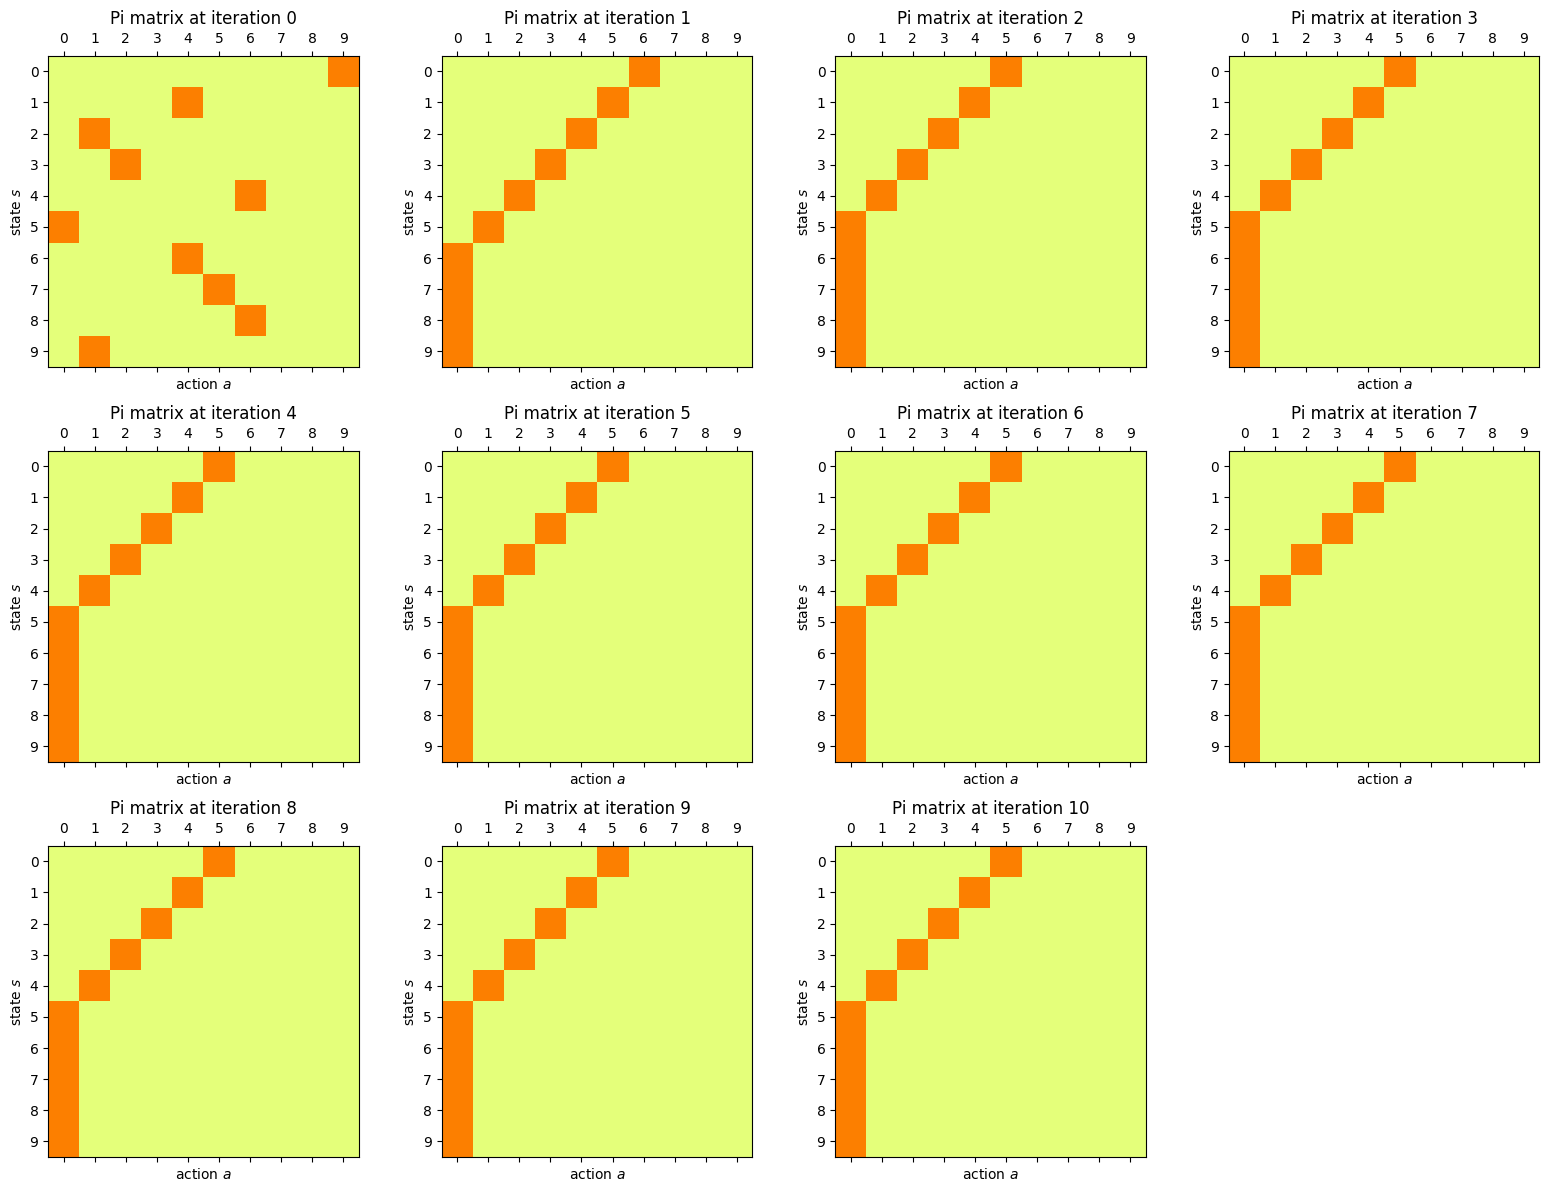

In [348]:
iterations = 10
pi_matrix_logs = PolicyIteration(env, iterations, gamma)

# Plot
ncols = 4
nrows = iterations//ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(16,12))
for i in range(iterations+1):
    idx = (i//ncols, i%ncols)
    axes[idx].matshow(pi_matrix_logs[i], cmap='Wistia')
    axes[idx].set_xticks(range(iterations))
    axes[idx].set_yticks(range(iterations))
    axes[idx].set_title(f"Pi matrix at iteration {i}")
    axes[idx].set_ylabel(r"state $s$")
    axes[idx].set_xlabel(r"action $a$")
plt.tight_layout()
plt.delaxes(axes[nrows-1, ncols-1])

The figure above shows the evolution of the policy (10,10) matrix throughout the iterations, an orange square at position (s,a) represents a probability of 1 to take action a at state s, and a yellow square represents a probability of 0. <br>
We know the algorithm has converged, because the pi_matrix doesn't change after iteration 3.
The strategy seems to be : 
- when $s<5$, to maintain the stock at 5 bikes
- when $s \geq 5$, to buy 0 bikes

In [351]:
best_policy = pi_matrix_logs[-1]
best_value = env.value_policy(best_policy, gamma)
best_value

array([12.66641819, 13.06641819, 13.46641819, 13.86641819, 14.26641819,
       14.66641819, 15.05591511, 15.37589753, 15.65065105, 15.89190991])

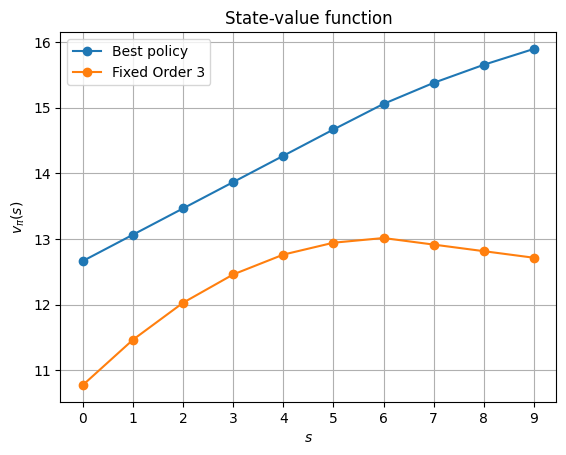

In [352]:
plt.plot(best_value, label="Best policy", marker="o")
plt.plot(FixOrd3_Pi, label="Fixed Order 3", marker="o")
plt.grid(True)
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$v_{\pi}(s)$")
plt.title("State-value function")
plt.xticks(range(10));

The policy obtained with the policy iteration method is better than the fixed order 3

### Q3. Q Learning
**Implement the asynchronous Q-Learning algorithm using the purely random policy (all actions selected uniformly) as the exploration policy** (note: this requires only about 10 lines of code). **Plot the convergence of the algorithm** both in terms of convergence of the state-action value table $Q_t$ and of convergence of the value function of the associated greedy policy $\pi_{t+}(s) = \arg\max_a Q_t(s,a)$. Use a single trajectory of length $n = 10,000$ and **test different schemes of decrease** of the learning rate (following the course guidelines). 

In [353]:
def AsyncQLearning(env, gamma, n, beta, log_interval):
    # Initialization
    env.reset(np.random.randint(0,9))
    Q = np.zeros(shape=(env.m+1, env.m+1), dtype=np.float64)
    N = np.zeros(shape=(env.m+1, env.m+1), dtype=np.int16)
    Q_history = [Q.copy()]
    alpha = lambda x : math.pow(x, -beta)
    for i in range(n):
        a = np.random.randint(low=0, high=env.m+1)
        s = env.state
        x = env.step(a)
        s_ = env.state # s_ is the new state
        N[s,a] += 1
        Q[s,a] = Q[s,a] + alpha(N[s,a]) * (x + gamma*max(Q[s_,:]) - Q[s,a])
        if i%log_interval == 0:
            Q_history.append(Q.copy())
    return N, Q, Q_history

To plot the convergence of the Q table, we need to compute the optimal Q which we can do because we have access to the environment transitions probabilities/rewards functions thanks to the iterative methods (just like in Question 2). <br> 
I can then plot the mean absolute difference between the Q at each iteration and the optimal Q

In [354]:
def GreedyQ_Operator(p, r, Q, gamma):
    v = np.max(Q, axis=-1)
    return r + gamma * np.sum( np.multiply(p, v), axis=-1)

def OptimalQ(env, iterations, gamma, show_progress=True):
    # Initialization
    p = env.transition_function() # shape : (|S|,|A|,|S|)
    r = env.reward_function() # shape : (|S|,|A|)
    Q = np.zeros(shape=(m+1,m+1))
    for i in range(iterations):
        Q = GreedyQ_Operator(p, r, Q, gamma)
    return Q

In [355]:
bestQ = OptimalQ(env, 100, gamma)

In [356]:
# Verifying the associated policy
np.argmax(bestQ, -1)

array([5, 4, 3, 2, 1, 0, 0, 0, 0, 0], dtype=int64)

We've computed the optimal Q, let's compare it to the successive values of Q table learned by the Asynchronus Q Learninga algorithm

In [357]:
# <1 min
Qdifference = dict()
Vdifference = dict()
n = 10000
log_interval = 100
betas = [0.55, 0.6, 0.7, 0.8, 0.9, 1.0]

for beta in betas:
    _, _, Q_history = AsyncQLearning(env, gamma, n, beta, log_interval)
    Qdifference[f"beta={beta}"] = []
    Vdifference[f"beta={beta}"] = []
    # For every log_interval (e.g. 100) iterations, compute the difference between the Q at that iteration and the optimal Q
    # same thing for the value function
    for i in range(n//log_interval + 1):
        Qdifference[f"beta={beta}"].append(np.abs(Q_history[i]-bestQ).mean())
        pi = get_deterministic_pi_matrix(np.argmax(Q_history[i], axis=-1), m)
        vpi = env.value_policy(pi, gamma)
        Vdifference[f"beta={beta}"].append(np.abs(vpi-best_value).mean())

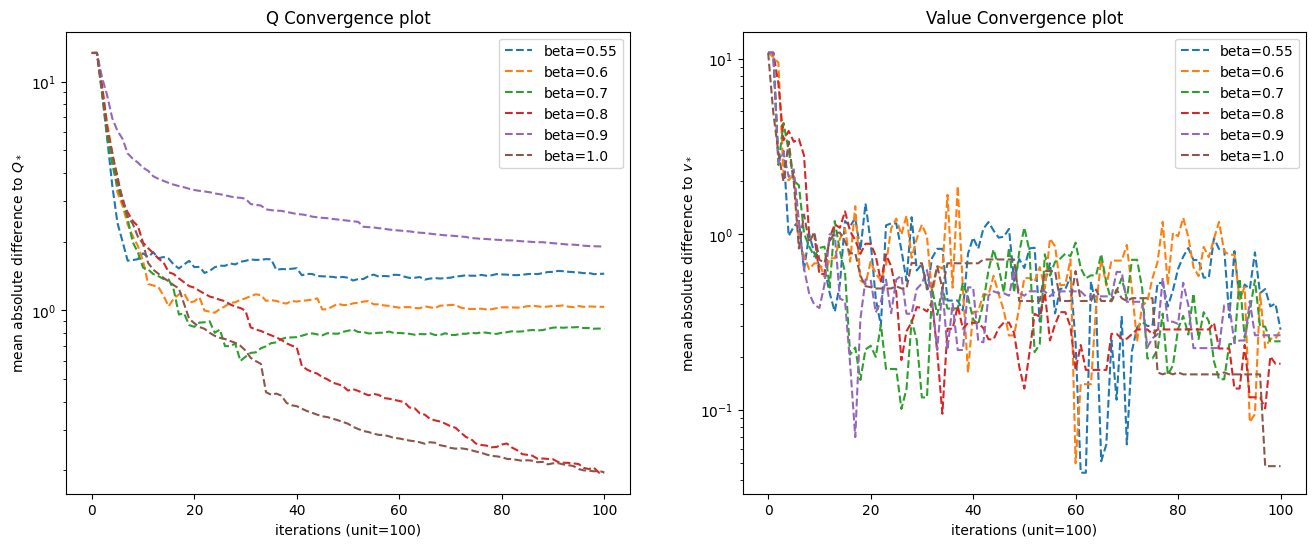

In [358]:
fig, (axL, axR) = plt.subplots(1,2, figsize=(16,6))

for beta in betas:
    axL.plot(Qdifference[f"beta={beta}"], label=f"beta={beta}", linestyle='--')
    axL.set_title("Q Convergence plot")
    axL.set_ylabel(r"mean absolute difference to $Q_*$")
    axL.set_xlabel(f"iterations (unit={log_interval})")
    axL.set_yscale("log")
    axL.legend()

    axR.plot(Vdifference[f"beta={beta}"], label=f"beta={beta}", linestyle='--')
    axR.set_title("Value Convergence plot")
    axR.set_ylabel(r"mean absolute difference to $v_*$")
    axR.set_xlabel(f"iterations (unit={log_interval})")
    axR.set_yscale("log")
    axR.legend()

The asynchronus Q Learning algorithm gives good results, it approaches the optimal solution. <br>
As for the impact of the $\beta$ parameter, a bigger $\beta$ means a slower decrease of the step size, and seems to give a more stable progress, but not as fast at the beginning as the lower $\beta$ values.<br>
For example, $\beta = 1.0$ or $\beta = 0.9$ is slow but is very stable (it doesn't have spikes), <br>
whereas $\beta = 0.55$ up to $\beta = 0.7$ the algorithm improves faster at the beginning, but has more variance. <br> 
There is a tradeoff between variance and speed of convergence that's problem dependent. We have theoretical guarantees of converges when :
$$ 
    \sum_{t \geq 0} \alpha_t = \infty , \sum_{t \geq 0} \alpha_t^2 < \infty \\
    \Leftrightarrow \beta \in \ )0.5, 1]

$$



$\beta = 1$ or $\beta = 0.9$ seems to give the best solution in this setting. It is sensitive to randomness, re-running the algorithm would give a slightly different result

In [359]:
N1, Q1, _ = AsyncQLearning(env, gamma, n, beta=1, log_interval=n)
N2, Q2, _ = AsyncQLearning(env, gamma, n, beta=0.9, log_interval=n)
N3, Q3, _ = AsyncQLearning(env, gamma, n, beta=0.8, log_interval=n)

In [360]:
N3

array([[232, 257, 237, 246, 212, 256, 254, 254, 237, 253],
       [ 82,  78,  84,  87,  89, 101,  91,  74,  78,  73],
       [ 99,  95,  93, 103, 101,  84,  93,  72, 117, 119],
       [103, 106,  98, 114, 111, 102,  98, 116, 112, 119],
       [118, 135, 116, 114, 115, 127, 124, 136, 118, 127],
       [128, 119, 122, 125, 131, 124, 135, 137, 134, 113],
       [104, 106, 124, 104,  99, 102, 126,  97, 107, 100],
       [ 69,  75,  69,  68,  76,  69,  70,  65,  74,  76],
       [ 33,  25,  33,  34,  30,  27,  33,  39,  28,  28],
       [ 12,   6,  10,  11,   8,   7,   9,   7,   5,   7]], dtype=int16)

As seen in the lectures, even with a uniform random policy, all state-action pairs aren't visited equally often.

**Let's compare the performance of Q-Learning algorithm to the optimal policy**

In [361]:
QL1_policy = np.argmax(Q1, axis=-1)
QL2_policy = np.argmax(Q2, axis=-1)
QL3_policy = np.argmax(Q3, axis=-1)
print(QL1_policy)
print(QL2_policy)
print(QL3_policy)

[6 4 3 4 3 1 2 0 0 1]
[5 6 3 3 1 1 1 0 0 0]
[6 6 4 4 2 1 0 0 1 0]


We know the optimal policy is [5 4 3 2 1 0 0 0 0 0]. Even for the highly visited states and 10 000 iterations, Asynchronus Q-Learning struggles to get to the optimal policy. <br>
But we do see somewhat of a decreasing action when the previous stock is increasing

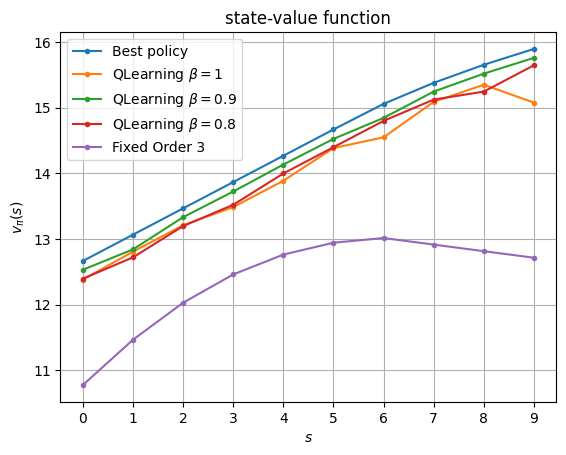

In [362]:
plt.plot(best_value, label="Best policy", marker=".")
plt.plot(env.value_policy(get_deterministic_pi_matrix(QL1_policy, env.m), gamma), label=r"QLearning $\beta = 1$", marker=".")
plt.plot(env.value_policy(get_deterministic_pi_matrix(QL2_policy, env.m), gamma), label=r"QLearning $\beta = 0.9$", marker=".")
plt.plot(env.value_policy(get_deterministic_pi_matrix(QL3_policy, env.m), gamma), label=r"QLearning $\beta = 0.8$", marker=".")
plt.plot(FixOrd3_Pi, label="Fixed Order 3", marker=".")
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$v_{\pi}(s)$")
plt.xticks(range(10))
plt.grid(True)
plt.title("state-value function");

As expected, QLearning approaches the optimal solution in value function, $\beta = 0.9$ seems to be the best step size decrease rate

### Q4. Policy Gradient

We will now consider using policy gradient from a set of simulated trajectories using the REINFORCE formula to approximate the gradient of the value function. To do so, we consider a log-linear parameterization of the policy and provide the two utility functions below.

<code>policy_features</code> Computes a $2(m+1)$--dimensional feature vector $\phi(s,a)$ corresponding to the state-action pair $(s,a)$.

<code>policy_choice</code> Computes the vector $\pi_\theta(s,:)$ of action probabilities using the softmax operator:
$$
    \pi_\theta(s,a) = \frac{\exp\left(\theta^T \phi(s,a)\right)}{\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)}
$$
You should check from the code that the matrix $(\theta^T \phi(s,a))_{0\leq s,a \leq n}$ is a weighted sum of the $m+1$ fixed ordering policies and of the $m+1$ threshold policies (which you should have met already...)

In [363]:
# Policy gradient utility functions (do NOT modify this code block)

def policy_features(s, a, m):
    """Returns the feature vector corresponding to state (s,a)."""
    f = np.zeros(2*(m+1))
    # Index of the fixed ordering policy that is non zero in (s,a)
    f[a] = 1
    # Indices of the threshold policies that are non zero in (s,a)
    if (s+a <= m):
        f[(m+1)+s+a] = 1
    if (a == 0):
        for i in range(0,s+1):
            f[(m+1)+i] = 1
    return f

def policy_choice(s, m,theta):
    """Returns the vector of action probabilities pi(s,:) corresponding to state s and parameter theta."""
    pi = np.zeros(m+1)
    # Note : Computation in log to avoid numerical underflows
    for a in range(m+1):
        pi[a] = np.dot(policy_features(s, a, m), theta)
    pi = pi - np.max(pi)
    pi = np.exp(pi)/np.sum(np.exp(pi))
    return pi

In [364]:
policy_features(3,0,m)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0.])

$\theta^T \phi(s,a)$ is simply the dot product of the features, and the parameter vector $\theta$, where the first m+1 index of $\phi(s,a)$ represent the fixed-order policies, so the product makes a sum of those policies weighted by the $\theta$ parameters

**Code a function** <code>policy_gradient</code> that computes the gradient $\nabla_\theta \log\pi_\theta(s,a)$ of $\pi_\theta(s,a)$. First **write in the text block below the LaTeX formula implemented by the function, explaining how you obtain this formula.**

\begin{aligned}
    \pi_\theta (s,a) &= \frac{\exp\left(\theta^T \phi(s,a)\right)}{\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)}\\
    \ \log \pi_{\theta}(s,a) &= \theta^T \phi(s,a) - log(\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right) )\\
    \nabla_{\theta} \ log \pi_\theta(s,a) &= \phi(s,a) - \frac{\nabla_\theta \sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)}{\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)} \\
     &= \phi(s,a) - \frac{\sum_{a'=0}^m \nabla_\theta \exp (\theta^T \phi(s,a'))}{\sum_{b'=0}^m \exp\left(\theta^T \phi(s,b')\right)} \tag {1}\\
     &= \phi(s,a) - \frac{\sum_{a'=0}^m  \phi(s,a') \exp(\theta^T \phi(s,a'))}{\sum_{b'=0}^m \exp\left(\theta^T \phi(s,b')\right)} \\
     &= \phi(s,a) - \sum_{a'=0}^m \phi(s,a') \frac{\exp(\theta^T \phi(s,a'))}{\sum_{b'=0}^m \exp\left(\theta^T \phi(s,b')\right)} \\
    \nabla_{\theta} \ log \pi_\theta(s,a) &= \phi(s,a) - \sum_{a'=0}^m \phi(s,a') \pi_\theta(s,a') 
\end{aligned}

In (1), by substituting the sum indexed over a' with the sum indexed over b' in the denominator, we can explicitly express the appearance of the term $\pi_\theta(s,a')$.

In [365]:
# --- Your answer here ---
def policy_gradient(s, a, m, theta):
    grad = policy_features(s, a, m) # \phi(s,a)
    pi = policy_choice(s, m, theta) # \pi(s,:)
    for a_prime in range(m+1):
        grad -= policy_features(s,a_prime,m) * pi[a_prime]
    return grad

Verifying my gradient implementation...

In [367]:
delta = 1e-9
s, a = 1,3
theta = np.random.randn(2*(m+1))
vector = np.ones(2*(m+1))
pi = policy_choice(s,m,theta)[a]
pi_ = policy_choice(s,m,theta+delta*vector)[a]
print("Gradient approximation around theta :", (np.log(pi_) - np.log(pi))/delta)
print("Gradient with explicit formula :", policy_gradient(s,a,m,theta).dot(vector))

Gradient approximation around theta : 0.013284484623454773
Gradient with explicit formula : 0.013284342924864127


**Implement the policy gradient algorithm** approximating the gradients using the REINFORCE formula
$$
  \sum_{t=0}^{n} \gamma^t \left(\sum_{i=0}^{n} \gamma^i X_{t+i} \right) \nabla_\theta \log \pi_\theta(S_t, A_t)
$$
computed on trajectories of length 35 started from a random initial state and using 200 iterations of SGD updates. To do so, complete the code template provided below. **Monitor the convergence of the algorithm by plotting the difference between the mean of the optimal value function and the mean of the value functions corresponding to successive values of $\theta$ (explain why one considers the mean).**

I will refer to gt as $\left (\sum_{i=0}^{n-t} \gamma^i X_{t+i} \right)$ (the observed remaining return)<br>

and grad_log_pi as $\nabla_\theta \log \pi_\theta(S_t, A_t)$

In [368]:
# --- Edit this block ---
def REINFORCE(nb_iter, n, env, seed=1):
    # Initialization
    # --------------
    np.random.seed(seed)
    theta = np.zeros(2*(m+1))
    theta_logs = [theta.copy()]
    # GAMMA stores the values gamma to the powers {0,1,2,...,n} in an array to avoid recomputing them. Such that GAMMA[t] = \gamma^t
    GAMMA = np.power(gamma, np.arange(n))

    # Core part of the algorithm
    # --------------------------
    for i_iter in range(nb_iter):
        # Compute the REINFORCE approximation of the gradient of the value function from a run of length n
        # of the MDP initialized t a random state and using the policy corresponding to the current value of theta
        env.reset(np.random.randint(0,m+1))
        S, A, X = [], [], []
        # Sample a trajectory and store the result
        for t in range(n):
            S.append(env.state)
            pi = policy_choice(S[-1], env.m, theta)
            A.append(np.random.choice(env.m+1, p=pi))
            X.append(env.step(A[-1]))

        # For that trajectory, compute the gradient approximation
        grad = np.zeros(shape=(2*(m+1)))
        for t in range(n):
            # policy gradient wrt theta at (S[t], A[t])
            grad_log_pi = policy_gradient(S[t], A[t], m, theta)
            # observed remaining return
            gt = sum([GAMMA[i] * X[t+i] for i in range(n-t)])
            grad += GAMMA[t] * gt * grad_log_pi

        # Do a step of SGD update on theta
        theta += 0.1*np.power(1+i_iter, -0.6)*grad
        theta_logs.append(theta.copy())

    return theta_logs, theta

The REINFORCE algorithm is not guaranteed to converge a global optimum, therefore we will set the random seed and run the algorithm with multiple seeds to compare them

In [369]:
# < 30 seconds
# Running the algorithm for 5 seeds
# ----------------------------------
n = 35
nb_iter = 200
theta_logs = dict()
final_theta = dict()
SEEDS = range(5)

for seed in SEEDS:
    seed_theta_logs, _ = REINFORCE(nb_iter, n, env, seed=seed)
    theta_logs[f"seed{seed}"] = seed_theta_logs

In [370]:
def theta_to_value(theta):
    '''Computes the value function associated to a given theta.'''
    pi_matrix = np.zeros(shape=(m+1,m+1))
    for s in range(m+1):
        pi_matrix[s] = policy_choice(s, m, theta)
    return env.value_policy(pi_matrix, gamma)
# Example
theta_to_value(np.zeros(2*(m+1)))

array([7.02507498, 7.39818715, 7.67253293, 7.85320503, 7.95085558,
       7.98064288, 7.95925572, 7.90209205, 7.8217964 , 7.72806234])

**Let's compute the difference in mean value to the optimal mean value**

In [371]:
# < 3 min
# Computing the mean value corresponding to successive values of theta and its difference to the optimal value
# ---------------------------------
diff = dict()
best_value_mean = best_value.mean()
for seed in SEEDS:
    diff[f"seed{seed}"] = []
    for iter in range(nb_iter+1):
        theta_mean_value = theta_to_value(theta_logs[f"seed{seed}"][iter]).mean()
        diff[f"seed{seed}"].append(theta_mean_value - best_value_mean)

Since the policy gradient algorithm is adapted to continuous state space (or very large $|\mathcal S|$). <br> 
We'd rather consider the mean value, because $\theta$ gives a value function for all possible states in a continuous fashion

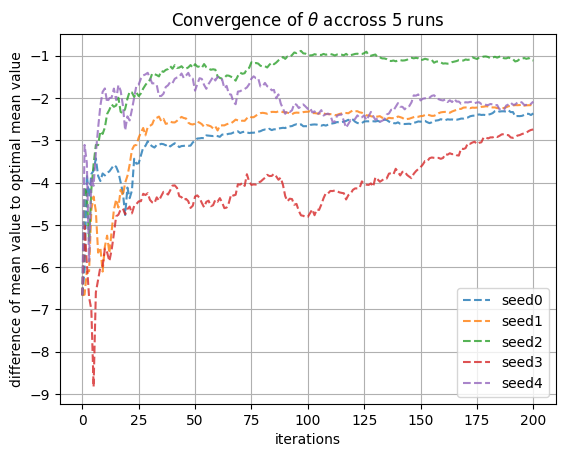

In [372]:
for seed in SEEDS :
    plt.plot(diff[f"seed{seed}"], label=f"seed{seed}", alpha=0.8, linestyle="--")
plt.title(r"Convergence of $\theta$ accross 5 runs")
plt.ylabel(r"difference of mean value to optimal mean value")
plt.legend()
plt.xlabel("iterations")
plt.grid(True);

We see that the algorithm is very sensitive to randomness, out of 5 runs, only one yielded a decent result. <br>

In [378]:
final_theta = theta_logs["seed2"][-1].copy()
for s in range(m+1):
    print(f"State s={s}, action :", np.random.choice(range(m+1), p=policy_choice(s, m, final_theta)))

State s=0, action : 5
State s=1, action : 8
State s=2, action : 2
State s=3, action : 2
State s=4, action : 1
State s=5, action : 4
State s=6, action : 1
State s=7, action : 2
State s=8, action : 1
State s=9, action : 8


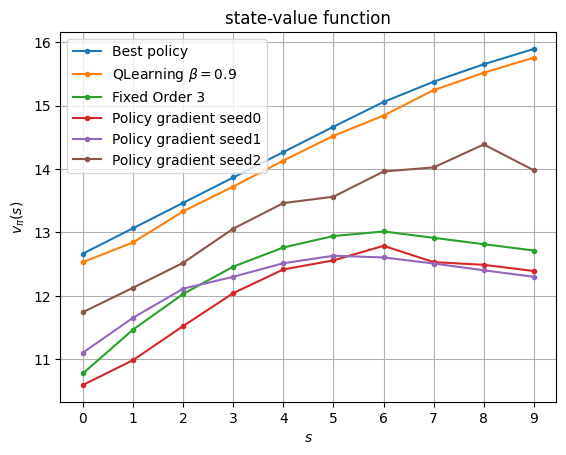

In [376]:
plt.plot(best_value, label="Best policy", marker=".")
plt.plot(env.value_policy(get_deterministic_pi_matrix(QL2_policy, env.m), gamma), label=r"QLearning $\beta = 0.9$", marker=".")
plt.plot(env.value_policy(get_deterministic_pi_matrix([3]*(m+1),m), gamma), label="Fixed Order 3", marker=".")
for seed in [0,1,2]:
    plt.plot(theta_to_value(theta_logs[f"seed{seed}"][-1]), label=f"Policy gradient seed{seed}", marker=".")
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$v_{\pi}(s)$")
plt.xticks(range(10))
plt.title("state-value function")
plt.grid(True);

**CONCLUSION**

As simple as this retail store problem might seem, the optimal policy is not trivial, a fixed-order strategy is far from optimal. <br>
For finite and relatively small state and action space, if we know the environment's transition probabilities and reward functions we can use the policy iteration algorithm which gives the best policy. <br>
If we do not have the transition probabilities, we can use a Temporal Difference algorithm like Asynchronus Q Learning which yields good results for a cheap computational cost for a small state and action space. <br>
Otherwise if the state space is continuous or very large, we can use a Function Approximation-based algorithm like the policy gradient method with the REINFORCE formula. Even for a small toy problem like this, this algorithm doesn't always give the optimal policy.